In [675]:
# pip instal sentencepiece
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from pytorch_pretrained_bert import BertForSequenceClassification,BertConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import fastai
from fastai import *
from fastai.text import * 
import sentencepiece as spm


In [1357]:
##Fine tuning LM on movies dataset

ratings = pd.read_excel("ratings.xlsx", encoding='utf-8', sep='\t', header=[0])
data = pd.read_excel("10k moviemetadatahindi.xlsx", encoding='utf-8', sep='\t', header=[0],sheet_name='Sheet2')

dataset =  pd.merge(data[['id','imdb_id','overview','genres']].copy(),ratings, how = 'inner', left_on ='id', right_on = 'movieId')
dataset = dataset[:20000].copy()

df = pd.DataFrame({'label':dataset.rating, 'text':dataset.overview,'userid':dataset.id,'genre':dataset.genres})
df = df.reset_index(drop = True)
# print(df)

for i in range(0, 1):                                                     
    df['text'] = df['text'].str.replace('।', '') 
    df['text'] = df['text'].str.replace(',', '') 
    df['text'] = df['text'].str.replace("'", '') 
    df['text'] = df['text'].str.replace(":", '') 
    df['text'] = df['text'].str.replace("{", '')
    df['text'] = df['text'].str.replace("}", '') 

    print(df)

tokenized_doc = df['text'].apply(lambda k: list(k.split(" ")))
print(tokenized_doc)


detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df['text'] = detokenized_doc

from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.2, random_state = 12)


       label                                               text  userid  \
0        3.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
1        5.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
2        1.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
3        4.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
4        4.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
5        3.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
6        3.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
7        4.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
8        4.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
9        4.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
10       3.0  वुडी के नेतृत्व में एंडी के खिलौने उनके कमरे म...     862   
11       4.0  एक वयस्क जो खेल के अंदर 26 साल के लिए फंस गया ...    8844   
12       4.5  एक वयस्क जो

0        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
1        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
2        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
3        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
4        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
5        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
6        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
7        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
8        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
9        [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
10       [वुडी, के, नेतृत्व, में, एंडी, के, खिलौने, उनक...
11       [एक, वयस्क, जो, खेल, के, अंदर, 26, साल, के, लि...
12       [एक, वयस्क, जो, खेल, के, अंदर, 26, साल, के, लि...
13       [एक, वयस्क, जो, खेल, के, अंदर, 26, साल, के, लि...
14       [एक, वयस्क, जो, खेल, के, अंदर, 26, साल, के, लि...
15       [जुनूनी, मास्टर, चोर, नील, मक्सौली, लॉस, एंजिल...
16       [जुनूनी, मास्टर, चोर, नील, मक्सौली, लॉस, एंजिल.

In [1343]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str("hindi_lm_large.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)
    

In [1344]:
sp = spm.SentencePieceProcessor()
sp.Load(str("hindi_lm_large.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]  
    
hindi_vocab = Vocab(itos)
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "",tokenizer=tokenizer,vocab=hindi_vocab)
learn = language_model_learner(data_lm, drop_mult=0.7, arch=AWD_LSTM, pretrained=False) 
##we have to make pretrained as false so that it doesn't load weights from pre-trained model

In [1345]:
learn.load('model')
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.254105,0.099766,0.980152,27:31


In [1346]:
learn.model[0]

AWD_LSTM(
  (encoder): Embedding(30000, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(30000, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [722]:
# print(len(df_trn['text'].values[1]))
# print((df_trn['text'].values[1]))
# print(tokenized_doc)
# tokenized_doc.apply(lambda m : tokenized_word.append(m))
# print(tokenized_word[0])
# df_trn['text']= df['text'].apply(lambda k: list(k.split(" ")))
# df['text']=tokenized_doc

In [695]:
# df_trn=df_trn.reset_index(drop =True)

# a=df_trn['text']
# print(a[5])
# for i in range(0,len(df_trn['text'])):
#     df_trn['text'].values[i]=learn.model[0](learn.data.one_item(a[i])[0])

In [1358]:
from torch.utils.data import Dataset, DataLoader

class HindiDataset(Dataset):
    
    def __init__(self, data):
        """
        Characterizes a Dataset for PyTorch
    
        Parameters
        ----------
    
        pass a dataframe with userid, label, text
        
        """
        self.n = data.shape[0]
        self.userid =  data['userid'].tolist()
        self.label = data['label'].tolist()
        self.hindiSent =  data['text'].tolist()

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return  self.label[idx], self.hindiSent[idx], self.userid[idx]
    
    
# dataset = HindiDataset(data=df)
# dataloader = DataLoader(dataset, 64, shuffle=True, num_workers=1)    

In [1359]:
train_df=HindiDataset(data=df_trn)
train_loader = DataLoader(train_df, 64, shuffle=True, num_workers=1)  
val_df=HindiDataset(data=df_val)
val_loader = DataLoader(val_df, 64, shuffle=True, num_workers=1)

In [1360]:
vocab_size=1200
embed_size = 100
n_hidden = 128
n_layers = 3
batchSize=64
output_size=11
n_user=len(df_trn['userid'].unique())
print(n_user)
max_user=max(df_trn['userid'].unique())+1

seq_length=150 

122


In [1361]:
class UserEmbedding(nn.Module):
    def __init__(self,vocab_size, n_user,embed_size,n_hidden,n_layers,output_size, batchSize
             , batch_first=True,):

        super(UserEmbedding,self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_batch = batchSize

        self.encoder_layer = learn.model[0]

        #self.awd = AWD_LSTM(vocab_sz = 30000, emb_sz = 400, n_hid=1152, n_layers =3)
        self.linear1 = nn.Linear(400,100)
        #self.linear2 = nn.Sequential(self.awd, self.linear1)
        self.linear3 = nn.Linear(400, 64)

        self.embedding = nn.Embedding(max_user, embed_size)

        self.linear7 = nn.Linear(200,32) 
        self.linear8 = nn.Linear(32,output_size)

    def forward(self, sents, users, hidden):

        b=(learn.data.one_item(sents[0]))
        raw_outputs,outputs=self.encoder_layer(b[0])
        lstm_out = raw_outputs[2]           
        lstm_out_mean1 = lstm_out.mean(1)
        
        for i in range(1,len(sents)):
            b=(learn.data.one_item(sents[i]))
            raw_outputs,outputs = self.encoder_layer(b[0])
            lstm_out = raw_outputs[2]  
           
            lstm_out_mean = lstm_out.mean(1)
            lstm_out_mean1=torch.cat((lstm_out_mean1,lstm_out_mean),dim=0)
        
        out1 = F.relu(torch.FloatTensor(self.linear1(lstm_out_mean1)))

        userEmbed = self.embedding(users)
        out3 = torch.cat((out1, userEmbed), dim=1)

        out3 = F.relu(self.linear7(out3))
        out3 = self.linear8(out3)
#         out3 = self.linear9(out3) 
#         print(out3,"out3:")
        return out3,hidden

    def init_hidden(self):

        weight = next(self.parameters()).data            
        hidden = (weight.new(self.n_layers,self.n_batch,self.n_hidden).zero_(),
                  weight.new(self.n_layers,self.n_batch,self.n_hidden).zero_())

        return hidden

In [1362]:
learn.model.reset()
model = UserEmbedding(vocab_size,n_user,embed_size,n_hidden,n_layers,output_size,batchSize,output_size)
# print(model)

In [1363]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
print(len(df_trn))

16000


In [1364]:
model.train()
losses = []
total_loss=[]
predicted_rating=[]
accuracy_list=[]
for i in range(0,20):
    correct1=0
    
    for label,text,userid in train_loader:
        model.zero_grad()
    
        hidden =  model.init_hidden()
        hidden = ([each.data for each in hidden])
        output1,hidden  = model(text,userid,hidden)
        _, predicted= torch.topk(output1,k=1)  
        predicted=predicted.type(torch.DoubleTensor)
        correct=predicted.data.eq(label.data.view_as(predicted.data)).sum()    ###taking sum of all corrected values for a batch
#         print(correct)
        correct1=correct1+correct.item()
#         print(correct1)
        lloss1= loss(output1, label.long())
        lloss1.backward()
        optimizer.step()
#         break 
    accuracy=(correct1/len(df_trn))*100
    accuracy_list.append(accuracy)    
    print(correct1/len(df_trn),accuracy_list)
    

0.3200625 [32.00625]
0.3309375 [32.00625, 33.09375]
0.329875 [32.00625, 33.09375, 32.9875]
0.3349375 [32.00625, 33.09375, 32.9875, 33.49375]
0.3306875 [32.00625, 33.09375, 32.9875, 33.49375, 33.06875]


Process Process-561:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x126cbf6a8>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
Tracebac

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1364-b2f9e129f7c9>", line 22, in <module>
    lloss1.backward()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/tensor.py", line 118, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/autograd/__init__.py", line 93, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._ren

KeyboardInterrupt: 

In [1289]:
# print(df_trn)
max_user=max(df_trn['userid'].unique())
print(max_user)

144982


SyntaxError: invalid syntax (<ipython-input-788-c49cd1edcc68>, line 2)

In [1173]:
text = ('जुआ स्वर्ग के जीवन ऐ लास वेगास ऐ और उसके अंधेरे माफिया ुंडेरबेल्ली', 'जेम्स बॉन्ड जानूस सिंडीकेट की रहस्यमय सिर बेनकाब और ब्रिटेन पर')
# learn.data.one_item(text)

print(len(text))
for i in range(0,1):
    b = learn.data.one_item(text[i])
    print(b)
#     print((b[0]))
    print(b[0].shape)
    raw,out = learn.model[0](b[0])
    print((raw[2].shape))
    

2
(tensor([[ 2963,  2906,  7891,   204, 17318,  3770,     3,   199,  1227,  7925,
         10493,  1227,    10,   135, 17343, 24411,     9,   508,  9087,    94,
          1550,  6561]]), tensor([0]))
torch.Size([1, 22])
[tensor([[[-2.2595e-02, -9.3924e-04, -4.6787e-01,  ...,  3.6226e-04,
          -2.3961e-02,  8.4022e-02],
         [-5.7533e-03,  4.1126e-03,  1.9538e-02,  ...,  1.0123e-01,
          -1.3887e-01, -1.4714e-01],
         [ 9.2288e-06,  1.4811e-03, -9.7586e-03,  ...,  8.1067e-01,
          -9.0614e-01,  3.7632e-01],
         ...,
         [ 1.9264e-02,  3.7402e-01,  3.2342e-02,  ...,  9.1470e-02,
           6.1285e-02, -1.2380e-01],
         [ 1.0562e-03, -2.3039e-01,  1.0042e-01,  ...,  4.8998e-02,
           1.3700e-01, -2.6615e-01],
         [ 8.6229e-04,  1.8219e-01,  3.9752e-02,  ...,  4.8402e-03,
           1.2127e-01, -2.1040e-01]]], grad_fn=<TransposeBackward0>), tensor([[[-0.0262,  0.0166,  0.0060,  ...,  0.0073,  0.0013, -0.0550],
         [-0.0068,  0.0692,  0.

In [1171]:
learn.model[0]

AWD_LSTM(
  (encoder): Embedding(30000, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(30000, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [313]:
a=learn.model[0]
sents='abccccc'
a(learn.data.one_item(sents)[0])

([tensor([[[ 0.0147,  0.0063, -0.0092,  ...,  0.0065, -0.0221, -0.0112],
           [ 0.0133,  0.0206, -0.0111,  ...,  0.0107, -0.0292, -0.0093],
           [ 0.0079,  0.0122, -0.0063,  ...,  0.0110, -0.0370, -0.0021],
           ...,
           [ 0.0018,  0.0251, -0.0063,  ...,  0.0191, -0.0279, -0.0019],
           [ 0.0139,  0.0147,  0.0039,  ...,  0.0184, -0.0235, -0.0056],
           [ 0.0046,  0.0101, -0.0002,  ...,  0.0078, -0.0296,  0.0008]]],
         grad_fn=<TransposeBackward0>),
  tensor([[[-0.0057, -0.0063, -0.0239,  ..., -0.0053, -0.0018, -0.0302],
           [-0.0073, -0.0049, -0.0212,  ..., -0.0064, -0.0014, -0.0296],
           [-0.0073, -0.0039, -0.0205,  ..., -0.0091, -0.0005, -0.0303],
           ...,
           [-0.0084, -0.0035, -0.0179,  ..., -0.0060,  0.0005, -0.0281],
           [-0.0082, -0.0028, -0.0187,  ..., -0.0065,  0.0010, -0.0296],
           [-0.0086, -0.0031, -0.0199,  ..., -0.0068,  0.0009, -0.0292]]],
         grad_fn=<TransposeBackward0>),
  tensor

In [18]:
ennc = learn.model[0](torch.tensor([[0,1,2]]))
print(len(ennc))

print((ennc[0][0].shape))
print((ennc[1][0].shape))
print((ennc[0][1].shape))


a='the'
# learn.model[0]
# print(learn.model[0](learn.data.one_item(a)[0]))

2
torch.Size([1, 3, 1152])
torch.Size([1, 3, 1152])
torch.Size([1, 3, 1152])


[<matplotlib.lines.Line2D object at 0x116947d30>, <matplotlib.lines.Line2D object at 0x116626908>, <matplotlib.lines.Line2D object at 0x116947e80>, <matplotlib.lines.Line2D object at 0x116955400>]


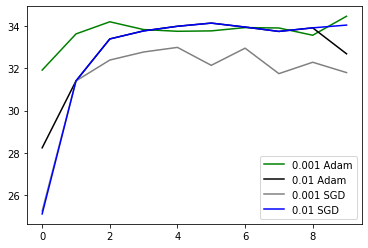

In [2]:
import matplotlib.pyplot as plt
import numpy as np
param_range=np.arange(0,10,1)
accuracy_list=31.918750000000003, 33.63125, 34.20625, 33.8375, 33.75625, 33.775, 33.93125, 33.9125, 33.56875, 34.46875
accuracy_list1=28.2369, 31.406250000000004, 33.39375, 33.775, 33.99375, 34.14375, 33.95625, 33.75, 33.918749999999996, 32.69
accuracy_list2=25.24500084, 31.406250000000004, 32.39375, 32.775, 32.99375, 32.14375, 32.95625, 31.75,32.29, 31.8
accuracy_list3=25.106250000000003, 31.406250000000004, 33.39375, 33.775, 33.99375, 34.14375, 33.95625, 33.75, 33.918749999999996, 34.050000000000004
w=plt.plot(param_range, accuracy_list, label="0.001 Adam", color="green")
x=plt.plot(param_range,accuracy_list1, label="0.01 Adam", color="black")
y=plt.plot(param_range,accuracy_list2, label="0.001 SGD", color="grey")
z=plt.plot(param_range,accuracy_list3, label="0.01 SGD", color="blue")
plt.legend()
print(w+x+y+z)